In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
%matplotlib inline
plt.style.use('ggplot')

# Import COVID Dataset

In [2]:
path = './data/kaggle/'
df_train = pd.read_csv(path + 'train.csv')
df_test = pd.read_csv(path + 'test.csv')
df_subm = pd.read_csv(path + 'submission.csv')

In [3]:
print(df_train.shape)
df_train.head()

(17040, 8)


,Id,Province/State,Country/Region,Lat,Long,Date,ConfirmedCases,Fatalities
0,1,NaN,Afghanistan,33.0,65.0,2020-01-22,0.0,0.0
1,2,NaN,Afghanistan,33.0,65.0,2020-01-23,0.0,0.0
2,3,NaN,Afghanistan,33.0,65.0,2020-01-24,0.0,0.0
3,4,NaN,Afghanistan,33.0,65.0,2020-01-25,0.0,0.0
4,5,NaN,Afghanistan,33.0,65.0,2020-01-26,0.0,0.0


In [4]:
print('Number of unique countries in train dataset: ', df_train['Country/Region'].nunique())

Number of unique countries in train dataset:  163


In [5]:
df_train['Date'] = pd.to_datetime(df_train['Date'])

## Calculate total number of cases per country as of 3/21 (last Date entry in train set)

In [6]:
# For countries without provinces/states, we can just get the entry from the last available date
countries_no_provinces = df_train.loc[df_train['Province/State'].isna()]
cases_countries_no_provinces = countries_no_provinces.loc[countries_no_provinces.groupby('Country/Region').Date.idxmax()]
cases_countries_no_provinces.head()


,Id,Province/State,Country/Region,Lat,Long,Date,ConfirmedCases,Fatalities
59,60,NaN,Afghanistan,33.0000,65.0000,2020-03-21,24.0,0.0
119,153,NaN,Albania,41.1533,20.1683,2020-03-21,76.0,2.0
179,246,NaN,Algeria,28.0339,1.6596,2020-03-21,139.0,15.0
239,339,NaN,Andorra,42.5063,1.5218,2020-03-21,88.0,0.0
299,432,NaN,Antigua and Barbuda,17.0608,-61.7964,2020-03-21,1.0,0.0


In [7]:
# For countries with provinces/states, find the total national number
# Get national numbers for Denmark, France, Netherlands and UK from filtering the 'Province/State'
countries_w_provinces = df_train.loc[~df_train['Province/State'].isna()]
cases_countries_w_provinces = countries_w_provinces.loc[countries_w_provinces.groupby(['Country/Region', 'Province/State']).Date.idxmax()]
total_cases_countries_w_provinces = cases_countries_w_provinces.loc[(cases_countries_w_provinces['Province/State']==cases_countries_w_provinces['Country/Region']) & (cases_countries_w_provinces['ConfirmedCases']>0)]

# Get national numbers for other 4 nations
regional_cases_countries_w_provinces = cases_countries_w_provinces.loc[~cases_countries_w_provinces['Country/Region'].isin(total_cases_countries_w_provinces['Country/Region'])]
national_cases_countries_w_provinces = regional_cases_countries_w_provinces.groupby('Country/Region').agg({'ConfirmedCases':'sum', 'Fatalities':'sum'}).reset_index()

train_cases = pd.concat([cases_countries_no_provinces, total_cases_countries_w_provinces, national_cases_countries_w_provinces])
train_cases = train_cases.drop(columns={'Id', 'Province/State', 'Lat', 'Long', 'Date'})

In [8]:
print(train_cases.shape)
train_cases

(163, 3)


,Country/Region,ConfirmedCases,Fatalities
59,Afghanistan,24.0,0.0
119,Albania,76.0,2.0
179,Algeria,139.0,15.0
239,Andorra,88.0,0.0
299,Antigua and Barbuda,1.0,0.0
...,...,...,...
0,Australia,1071.0,7.0
1,Canada,1277.0,19.0
2,China,81305.0,3259.0
3,Cruise Ship,712.0,8.0


# External Datasets

I got datasets from OECD and the World Bank relating to quality of health care and lifestyle by country. The data includes last three years of available information (2015-2018) for each data type. For each data type, I looked at the actual value in the last year with data available as well as the percentage change between the last year with data available and the year prior to that. Unfortunately, there is a lot of missing data for all data types.

Link: https://data.oecd.org/healthres/health-spending.htm

## Quality of Healthcare and Lifestyle

In [139]:
path = './data/external/'

# OECD Datasets 
flu_vaccine = pd.read_csv(path + 'flu_vaccine.csv')
medical_graduates = pd.read_csv(path + 'medical_graduates.csv')
nursing_graduates = pd.read_csv(path + 'nursing_graduates.csv')

oecd_names = ['flu_vaccine', 'medical_graduates', 'nursing_graduates']
oecd_df_list = [flu_vaccine, medical_graduates, nursing_graduates]


# World Bank Datasets: Health care
health_spending = pd.read_csv(path + 'wbg_health_exp_perc_gdp.csv')
hospital_beds = pd.read_csv(path + 'wbg_hospital_beds_per_1000.csv')

doctors = pd.read_csv(path + 'wbg_physicians_per_1000.csv')
nurses_midwives = pd.read_csv(path + 'wbg_nurses_midwives_per_1000.csv')

infant_mortality = pd.read_csv(path + 'wbg_infant_mort_per_1000_births.csv')
life_expectancy = pd.read_csv(path + 'wbg_life_expectancy.csv')

# World Bank Datasets: Lifestyle 
overweight = pd.read_csv(path + 'wbg_overweight_perc_of_adults.csv')
smokers = pd.read_csv(path + 'wbg_smokers_perc_of_pop_over_15.csv')
alcohol = pd.read_csv(path + 'wbg_alcohol_per_capita.csv')


wbg_names = ['health_spending', 'hospital_beds', 'doctors', 'nurses_midwives', \
          'infant_mortality', 'life_expectancy', 'overweight', 'smokers', 'alcohol']

wbg_df_list = [health_spending, hospital_beds, doctors, nurses_midwives, \
          infant_mortality, life_expectancy, overweight, smokers, alcohol]


In [140]:
for index, df in enumerate(oecd_df_list):
    print('# of countries present in ', oecd_names[index], ' dataset is: ', df.LOCATION.nunique())
    
for index, df in enumerate(wbg_df_list):
    print('# of countries present in ', wbg_names[index], ' dataset is: ', df.country.loc[~df[wbg_names[index]].isna()].nunique())
    

# of countries present in  flu_vaccine  dataset is:  29
# of countries present in  medical_graduates  dataset is:  36
# of countries present in  nursing_graduates  dataset is:  35
# of countries present in  health_spending  dataset is:  228
# of countries present in  hospital_beds  dataset is:  25
# of countries present in  doctors  dataset is:  186
# of countries present in  nurses_midwives  dataset is:  187
# of countries present in  infant_mortality  dataset is:  234
# of countries present in  life_expectancy  dataset is:  241
# of countries present in  overweight  dataset is:  229
# of countries present in  smokers  dataset is:  181
# of countries present in  alcohol  dataset is:  228


mmm... Turns out the World Bank Group includes regional stats as "country", which is why the number of countries present in their datasets is more than the number of countries in the world.

### Features with values and growth rate in values

In [141]:
flu_vaccine.head()

,LOCATION,INDICATOR,SUBJECT,MEASURE,FREQUENCY,TIME,Value,Flag Codes
0,CAN,FLUVACCIN,TOT,PC_POP65,A,2015,60.8,B
1,CAN,FLUVACCIN,TOT,PC_POP65,A,2016,59.8,NaN
2,CAN,FLUVACCIN,TOT,PC_POP65,A,2017,61.1,NaN
3,CZE,FLUVACCIN,TOT,PC_POP65,A,2015,19.3,NaN
4,CZE,FLUVACCIN,TOT,PC_POP65,A,2016,20.2,NaN


In [142]:
# Add a new column that calculates growth rate in alcohol consumption per country
flu_vaccine['growth'] = flu_vaccine.sort_values(by=['LOCATION', 'TIME'], ascending=[True,True]).groupby('LOCATION')['Value'].pct_change()

# Filter to include only relevant columns in the latest year with data available for each country
df_flu_vaccine = flu_vaccine.loc[flu_vaccine.groupby('LOCATION').TIME.idxmax()]
df_flu_vaccine = df_flu_vaccine[['LOCATION', 'Value', 'growth']]
df_flu_vaccine = df_flu_vaccine.rename(columns={'Value': 'flu_vaccine', 'growth': 'flu_vaccine_growth'})

print(df_flu_vaccine.shape)
df_flu_vaccine.head()


(29, 3)


,LOCATION,flu_vaccine,flu_vaccine_growth
2,CAN,61.1,0.021739
70,CHL,64.7,0.096610
5,CZE,20.3,0.004950
19,DEU,34.8,-0.014164
9,DNK,52.0,0.040000


In [143]:
df_feats_oecd = df_flu_vaccine.copy()
df_temp = pd.DataFrame()

oecd_names_mod = ['medical_graduates', 'nursing_graduates']
oecd_df_list_mod = [medical_graduates, nursing_graduates]

for index, df in enumerate(oecd_df_list_mod):
    df['growth'] = df.sort_values(by=['LOCATION', 'TIME'], ascending=[True,True]).groupby('LOCATION')['Value'].pct_change()

    # Filter to include only relevant columns in the latest year with data available for each country
    df_temp = df.loc[df.groupby('LOCATION').TIME.idxmax()]
    df_temp = df_temp[['LOCATION', 'Value', 'growth']]
    df_temp = df_temp.rename(columns={'Value': '{}'.format(oecd_names_mod[index]), 'growth': '{}_growth'.format(oecd_names_mod[index])})

    df_feats_oecd = pd.merge(df_feats_oecd, df_temp, on='LOCATION', how='outer')
    

In [144]:
df_feats_oecd.head()

,LOCATION,flu_vaccine,flu_vaccine_growth,medical_graduates,medical_graduates_growth,nursing_graduates,nursing_graduates_growth
0,CAN,61.1,0.021739,7.70,0.005222,52.47,-0.061192
1,CHL,64.7,0.096610,8.82,0.014960,30.02,0.038036
2,CZE,20.3,0.004950,17.13,0.134437,14.10,-0.109848
3,DEU,34.8,-0.014164,12.01,0.025619,54.49,-0.031117
4,DNK,52.0,0.040000,21.47,0.259238,43.98,0.010802


In [145]:
# Match country names with Kaggle file
countries = pd.read_csv(path + 'countries_key.csv')
countries.head()


,LOCATION,country
0,AUS,Australia
1,BEL,Belgium
2,CAN,Canada
3,CZE,Czech Republic
4,DNK,Denmark


In [146]:
# Add full country name to df_feats
df_feats_oecd = pd.merge(df_feats_oecd, countries, on='LOCATION', how='left')
df_feats_oecd = df_feats_oecd.drop(columns={'LOCATION'})
print(df_feats_oecd.shape)
df_feats_oecd.head()


(36, 7)


,flu_vaccine,flu_vaccine_growth,medical_graduates,medical_graduates_growth,nursing_graduates,nursing_graduates_growth,country
0,61.1,0.021739,7.70,0.005222,52.47,-0.061192,Canada
1,64.7,0.096610,8.82,0.014960,30.02,0.038036,Chile
2,20.3,0.004950,17.13,0.134437,14.10,-0.109848,Czech Republic
3,34.8,-0.014164,12.01,0.025619,54.49,-0.031117,Germany
4,52.0,0.040000,21.47,0.259238,43.98,0.010802,Denmark


In [161]:
df_feats = df_feats_oecd.copy()

for index, df in enumerate(wbg_df_list):
    df_feats = pd.merge(df_feats, df, on='country', how='outer')


In [171]:
# Modify country names to match what Kaggle's dataset are
df_feats = df_feats.loc[~df_feats.country.isna()]
df_feats.loc[df_feats['country'].str.contains('Korea'), 'country'] = 'Korea, South'
df_feats.loc[df_feats['country'].str.contains('Egypt, Arab Rep.'), 'country'] = 'Egypt'
df_feats.loc[df_feats['country'].str.contains('Russia Federation'), 'country'] = 'Russia'
df_feats.loc[df_feats['country'].str.contains('Venezuela, RB'), 'country'] = 'Venezuela'
df_feats.loc[df_feats['country'].str.contains('Bahamas'), 'country'] = 'The Bahamas'
df_feats.loc[df_feats['country'].str.contains('Iran'), 'country'] = 'Iran'
df_feats.loc[df_feats['country'].str.contains('Gambia'), 'country'] = 'The Gambia'
df_feats.loc[df_feats['country'].str.contains('Gambia'), 'country'] = 'The Gambia'
df_feats.loc[df_feats['country'].str.contains('United States'), 'country'] = 'US'
df_feats.loc[df_feats['country'].str.contains('Lucia'), 'country'] = 'Saint Lucia'
df_feats.loc[df_feats['country'].str.contains('Brunei'), 'country'] = 'Brunei'
df_feats.loc[df_feats['country'].str.contains('Guyana'), 'country'] = 'French Guiana'
             

/Users/Claudia/Documents/Python/env/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [172]:
df_feats.head()

,flu_vaccine,flu_vaccine_growth,medical_graduates,medical_graduates_growth,nursing_graduates,nursing_graduates_growth,country,health_spending,health_spending_growth,hospital_beds,...,nurses_midwives_growth,infant_mortality,infant_mortality_growth,life_expectancy,life_expectancy_growth,overweight,overweight_growth,smokers,smokers_growth,alcohol
0,61.1,0.021739,7.70,0.005222,52.47,-0.061192,Canada,10.534655,0.015241,NaN,...,0.006687,4.3,-0.022727,82.248976,0.002958,64.1,0.006279,14.3,-0.048951,8.9
1,64.7,0.096610,8.82,0.014960,30.02,0.038036,Chile,8.528940,0.027589,NaN,...,-1.000000,6.2,-0.015873,79.909000,0.001670,63.1,0.007987,37.8,-0.023810,9.3
2,20.3,0.004950,17.13,0.134437,14.10,-0.109848,Czech Republic,7.149599,-0.012862,6.5,...,0.004541,2.7,0.038462,79.475610,0.005711,62.3,0.004839,34.3,0.000000,14.4
3,34.8,-0.014164,12.01,0.025619,54.49,-0.031117,Germany,11.139168,0.005425,NaN,...,0.021092,3.1,-0.031250,80.990244,0.004325,56.8,0.007092,30.6,-0.009804,13.4
4,52.0,0.040000,21.47,0.259238,43.98,0.010802,Denmark,10.350040,0.007418,2.5,...,-0.401620,3.6,0.000000,81.004878,0.001874,55.4,0.005445,19.1,-0.041885,10.4


In [173]:
df_feats.columns

Index(['flu_vaccine', 'flu_vaccine_growth', 'medical_graduates',
       'medical_graduates_growth', 'nursing_graduates',
       'nursing_graduates_growth', 'country', 'health_spending',
       'health_spending_growth', 'hospital_beds', 'doctors', 'doctors_growth',
       'nurses_midwives', 'nurses_midwives_growth', 'infant_mortality',
       'infant_mortality_growth', 'life_expectancy', 'life_expectancy_growth',
       'overweight', 'overweight_growth', 'smokers', 'smokers_growth',
       'alcohol'],
      dtype='object')

### Merge features with Kaggle Train Set

In [174]:
# Number of countries with province/state info
df_all = pd.merge(train_cases, df_feats, left_on='Country/Region', right_on='country', how='left').set_index('Country/Region')
df_all = df_all.drop(columns={'country'})
print(df_all.shape)
df_all.head(10)

(165, 24)


,ConfirmedCases,Fatalities,flu_vaccine,flu_vaccine_growth,medical_graduates,medical_graduates_growth,nursing_graduates,nursing_graduates_growth,health_spending,health_spending_growth,...,nurses_midwives_growth,infant_mortality,infant_mortality_growth,life_expectancy,life_expectancy_growth,overweight,overweight_growth,smokers,smokers_growth,alcohol
Country/Region,,,,,,,,,,,,,,,,,,,,,
Afghanistan,24.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,10.198677,0.010374,...,NaN,47.9,-0.032323,64.130000,0.006091,23.0,0.031390,NaN,NaN,0.2
Albania,76.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,6.697895,-0.017867,...,-1.000000,7.8,-0.025000,78.333000,0.002166,57.7,0.012281,28.7,-0.013937,7.5
Algeria,139.0,15.0,NaN,NaN,NaN,NaN,NaN,NaN,6.648475,-0.047891,...,-1.000000,20.1,-0.024272,76.499000,0.002734,62.0,0.011419,15.6,0.006410,0.9
Andorra,88.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,10.367728,0.010384,...,-1.000000,2.7,-0.035714,NaN,NaN,63.7,0.003150,33.5,-0.005970,11.3
Antigua and Barbuda,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,4.309008,-0.086296,...,-1.000000,5.0,-0.038462,76.752000,0.001752,48.0,0.012658,NaN,NaN,7.0
Argentina,158.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,7.548384,-0.136668,...,-1.000000,8.8,-0.053763,76.372000,0.002011,62.7,0.006421,21.8,-0.032110,9.8
Armenia,160.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,9.927321,-0.018809,...,NaN,11.0,-0.051724,74.797000,0.002323,54.4,0.009276,24.1,-0.016598,5.5
Aruba,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,76.010000,0.001888,NaN,NaN,NaN,NaN,NaN
Austria,2814.0,8.0,NaN,NaN,14.41,0.033716,34.45,0.085039,10.437626,0.009160,...,0.000245,2.9,0.000000,81.641463,0.005558,54.3,0.007421,29.6,-0.033784,11.6


In [175]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Index: 165 entries, Afghanistan to US
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ConfirmedCases            165 non-null    float64
 1   Fatalities                165 non-null    float64
 2   flu_vaccine               27 non-null     float64
 3   flu_vaccine_growth        26 non-null     float64
 4   medical_graduates         34 non-null     float64
 5   medical_graduates_growth  33 non-null     float64
 6   nursing_graduates         33 non-null     float64
 7   nursing_graduates_growth  33 non-null     float64
 8   health_spending           137 non-null    float64
 9   health_spending_growth    136 non-null    float64
 10  hospital_beds             21 non-null     float64
 11  doctors                   115 non-null    float64
 12  doctors_growth            57 non-null     float64
 13  nurses_midwives           116 non-null    float64
 14  nurses

In [176]:
# df_all.to_csv('./healthcare_features.csv', index=True)

# Correlation Matrix between Covid-19 Cases and Health Care/Lifestyle Variables

In [177]:
def calculate_pvalues(df):
    
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            df_temp = df.copy()
            df_temp = df_temp.dropna(subset=[r,c], how='any', axis=0)
            pvalues[r][c] = round(pearsonr(df_temp[r], df_temp[c])[1], 4)
    return pvalues

In [178]:
pval = calculate_pvalues(df_all)

corrmat = round(df_all.corr(),2)

# create three masks
c1 = corrmat.applymap(lambda x: '{}*'.format(x))
c2 = corrmat.applymap(lambda x: '{}**'.format(x))
c3 = corrmat.applymap(lambda x: '{}***'.format(x))
# apply them where appropriate
corrmat = corrmat.mask(pval<=0.1, c1)
corrmat = corrmat.mask(pval<=0.05, c2)
corrmat = corrmat.mask(pval<=0.01, c3)


In [179]:
pval

,ConfirmedCases,Fatalities,flu_vaccine,flu_vaccine_growth,medical_graduates,medical_graduates_growth,nursing_graduates,nursing_graduates_growth,health_spending,health_spending_growth,...,nurses_midwives_growth,infant_mortality,infant_mortality_growth,life_expectancy,life_expectancy_growth,overweight,overweight_growth,smokers,smokers_growth,alcohol
ConfirmedCases,0,0,0.2796,0.2986,0.6282,0.8655,0.7533,0.7898,0.0262,0.6142,...,0.8019,0.0654,0.4074,0.0202,0.7987,0.7615,0.6216,0.342,0.584,0.2693
Fatalities,0,0,0.5398,0.5958,0.9878,0.9939,0.2566,0.8156,0.2381,0.7568,...,0.676,0.1655,0.3824,0.0566,0.3483,0.6702,0.6755,0.6046,0.4696,0.735
flu_vaccine,0.2796,0.5398,0,0.0012,0.2164,0.1402,0.3318,0.153,0.0021,0.0017,...,0.3906,0.8931,0.0003,0.0007,0.2666,0.5842,0.7061,0.0527,0.0875,0.5317
flu_vaccine_growth,0.2986,0.5958,0.0012,0,0.4499,0.5715,0.2808,0.1848,0.0459,0.1084,...,0.565,0.6941,0.132,0.0074,0.99,0.8225,0.9992,0.0774,0.2011,0.1003
medical_graduates,0.6282,0.9878,0.2164,0.4499,0,0,0.9171,0.7249,0.5576,0.7931,...,0.234,0.6575,0.4289,0.2107,0.8171,0.8778,0.2389,0.7337,0.5366,0.057
medical_graduates_growth,0.8655,0.9939,0.1402,0.5715,0,0,0.9208,0.766,0.9694,0.9737,...,0.5879,0.9768,0.46,0.5608,0.18,0.9743,0.1131,0.6082,0.3147,0.3639
nursing_graduates,0.7533,0.2566,0.3318,0.2808,0.9171,0.9208,0,0.2371,0.0011,0.685,...,0.9212,0.0643,0.2481,0.0521,0.451,0.348,0.6823,0.039,0.1056,0.5503
nursing_graduates_growth,0.7898,0.8156,0.153,0.1848,0.7249,0.766,0.2371,0,0.2452,0.4471,...,0.1104,0.0125,0.4173,0.6129,0.8859,0.3781,0.6277,0.8502,0.497,0.0071
health_spending,0.0262,0.2381,0.0021,0.0459,0.5576,0.9694,0.0011,0.2452,0,0.1355,...,0.0175,0,0.3412,0,0.1443,0,0,0.0129,0.0016,0
health_spending_growth,0.6142,0.7568,0.0017,0.1084,0.7931,0.9737,0.685,0.4471,0.1355,0,...,0.2727,0.0246,0.337,0.0335,0.3878,0.8202,0.5261,0.2334,0.6291,0.0189


In [180]:
corrmat

,ConfirmedCases,Fatalities,flu_vaccine,flu_vaccine_growth,medical_graduates,medical_graduates_growth,nursing_graduates,nursing_graduates_growth,health_spending,health_spending_growth,...,nurses_midwives_growth,infant_mortality,infant_mortality_growth,life_expectancy,life_expectancy_growth,overweight,overweight_growth,smokers,smokers_growth,alcohol
ConfirmedCases,1.0***,0.89***,0.22,-0.21,-0.09,-0.03,-0.06,-0.05,0.19**,0.04,...,0.02,-0.16*,-0.07,0.19**,0.02,0.03,-0.04,0.09,0.05,0.1
Fatalities,0.89***,1.0***,0.12,-0.11,-0,-0,-0.2,-0.04,0.1,0.03,...,0.04,-0.12,-0.07,0.16*,0.08,0.04,-0.04,0.05,0.07,0.03
flu_vaccine,0.22,0.12,1.0***,-0.6***,-0.25,-0.3,0.2,0.29,0.57***,-0.59***,...,-0.18,0.03,0.65***,0.62***,-0.23,0.11,0.08,-0.38*,-0.34*,-0.13
flu_vaccine_growth,-0.21,-0.11,-0.6***,1.0***,0.15,-0.12,-0.22,-0.27,-0.4**,0.33,...,0.12,-0.08,-0.31,-0.52***,0,-0.05,0,0.36*,0.26,0.34
medical_graduates,-0.09,-0,-0.25,0.15,1.0***,0.66***,0.02,0.06,-0.11,0.05,...,0.21,-0.08,-0.14,-0.22,0.04,0.03,-0.21,0.06,0.11,0.33*
medical_graduates_growth,-0.03,-0,-0.3,-0.12,0.66***,1.0***,0.02,0.05,0.01,0.01,...,0.1,0.01,-0.14,-0.11,0.24,-0.01,-0.29,0.09,0.18,0.17
nursing_graduates,-0.06,-0.2,0.2,-0.22,0.02,0.02,1.0***,0.21,0.55***,-0.07,...,0.02,-0.33*,0.21,0.35*,-0.14,-0.17,-0.08,-0.37**,-0.29,0.11
nursing_graduates_growth,-0.05,-0.04,0.29,-0.27,0.06,0.05,0.21,1.0***,0.21,-0.14,...,0.29,-0.44**,0.15,0.09,0.03,-0.16,-0.09,-0.03,-0.12,0.47***
health_spending,0.19**,0.1,0.57***,-0.4**,-0.11,0.01,0.55***,0.21,1.0***,0.13,...,0.22**,-0.4***,0.08,0.48***,-0.13,0.37***,-0.44***,0.23**,-0.29***,0.44***
health_spending_growth,0.04,0.03,-0.59***,0.33,0.05,0.01,-0.07,-0.14,0.13,1.0***,...,0.1,-0.19**,-0.08,0.18**,-0.08,-0.02,0.06,0.11,0.05,0.2**


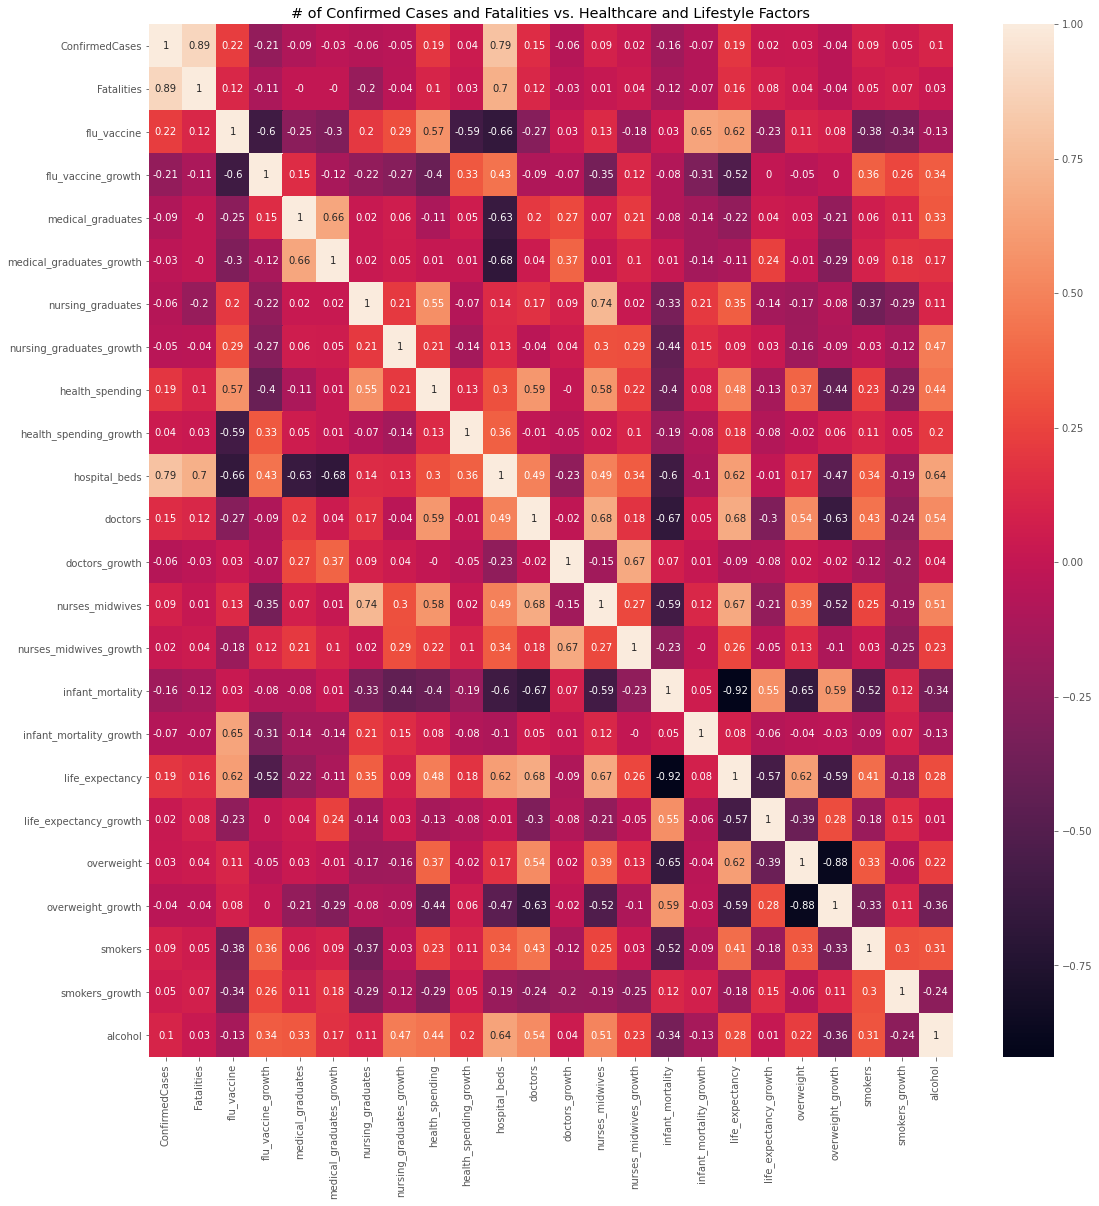

In [181]:
fig, ax = plt.subplots(figsize=(18,19))
sns.heatmap(round(df_all.corr(),2), annot=True, ax=ax)
plt.title('# of Confirmed Cases and Fatalities vs. Healthcare and Lifestyle Factors')
plt.savefig('./covid_healthcare_corr_mat.png', bbox_inches='tight')